# IMDB movie review analysis

### Overview

## Import necessary libraries

In [2]:
import json
import pandas as pd
import re
import nltk
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM , AutoModelForSequenceClassification

In [3]:
from google.colab import drive
drive.mount('/content/drive')
directory = '/content/drive/MyDrive/CA7/'

Mounted at /content/drive


## Download punktuations and stopwords for preprocessing

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Load data

In [5]:
train_data = []
test_data = []
unlabeled_data = []

def read_json(data, json_file):
    with open(json_file, 'r') as f:
        for line in f:
            line = line.strip()  # remove leading/trailing white spaces
            if line:  # ensure the line is not empty
                try:
                    data.append(json.loads(line))
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON: {e}")

read_json(train_data, directory + 'train_imdb.jsonl')
read_json(test_data, directory + 'test_imdb.jsonl')
read_json(unlabeled_data, directory + 'aug_imdb_unlabeled.jsonl')



In [6]:
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)
unlabeled_data = pd.DataFrame(unlabeled_data)


In [7]:
print(f"Unlabeled Data: {len(unlabeled_data)}")
print(f"Training Data: {len(train_data)}")
print(f"Test Data: {len(test_data)}")

Unlabeled Data: 1014
Training Data: 150
Test Data: 150


In [8]:
train_data.head(5)

,text,label,embedding
0,fairly good romantic comedy in which i don't t...,1,"[-0.0167805497, -0.0395836979, 0.1233159453, -..."
1,"""dressed to kill"", is one of the best thriller...",1,"[-0.1252697259, 0.1014768854, 0.1718291789, -0..."
2,i'm glad that users (as of this date) who like...,1,"[0.1312361956, 0.0294876788, 0.2328549027, -0...."
3,needed an excuse to get out of the house while...,0,"[0.1387384981, 0.0460377187, 0.3447172046, -0...."
4,john candy's performance in once upon a crime ...,1,"[0.1606466323, -0.1768193543, 0.3563380837, -0..."


In [9]:
test_data.head()

,text,label,embedding
0,the 60s (1999) d: mark piznarski. josh hamilto...,0,"[-0.2179879397, -0.1741176099, 0.0884851664, -..."
1,hello. this movie is.......well.......okay. ju...,1,"[-0.0783471093, -0.279764235, 0.6189775467, 0...."
2,eyeliner was worn nearly 6000 years ago in egy...,1,"[0.03139963, -0.1652034372, 0.1265712678, -0.0..."
3,"this has to be, by far, the absolute worst mov...",0,"[-0.0552324504, -0.1593759954, 0.0467776954, -..."
4,"i like silent films, but this was a little too...",0,"[0.0934860557, 0.0262434836, 0.0843501985, -0...."


In [10]:
unlabeled_data.head()

,text,embedding
0,there is no relation at all between fortier an...,"[-0.097577557, -0.1536363065, 0.311417222, 0.0..."
1,in the process of trying to establish the audi...,"[-0.0003366936, 0.0877778083, -0.0071643554, 0..."
2,i give this movie 7 out of 10 because the vill...,"[-0.275570631, -0.3291363716, 0.079317905, 0.0..."
3,this is the best sci-fi that i have seen in my...,"[0.1461943835, -0.2785910368, 0.4456491172, -0..."
4,what an appalling piece of rubbish!!! who are ...,"[0.1696606129, 0.354041934, 0.4451519549, -0.0..."


In [11]:
def check_list_sizes(df, column_name):
    list_lengths = df[column_name].apply(len)
    return list_lengths.nunique() == 1

# Usage
result = check_list_sizes(unlabeled_data, 'embedding')
print("All lists have the same size:", result)

All lists have the same size: True


## Preproccesing

The steps of cleaning the dataset:
- tokenize the texts
- make all the words in lowercase
- remove punctuations and stopwords
- stemmize words

In [12]:
def clean_text(text):
    text = re.sub(r"^[^-]*-\s*", "", text)
    text = re.sub(r"([^\w\s])", "", text)

    tokens = nltk.word_tokenize(text)
    remove_punct = str.maketrans('', '', string.punctuation)
    tokens = [token.lower().translate(remove_punct) for token in tokens]

    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # stemmer = PorterStemmer()
    # tokens = [stemmer.stem(token) for token in tokens]

    return tokens


In [13]:
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
test_data['cleaded_text'] = test_data['text'].apply(clean_text)
unlabeled_data['cleaned_text'] = unlabeled_data['text'].apply(clean_text)

In [14]:
train_data.head()

,text,label,embedding,cleaned_text
0,fairly good romantic comedy in which i don't t...,1,"[-0.0167805497, -0.0395836979, 0.1233159453, -...","[fairly, good, romantic, comedy, dont, think, ..."
1,"""dressed to kill"", is one of the best thriller...",1,"[-0.1252697259, 0.1014768854, 0.1718291789, -0...","[dressed, kill, one, best, thriller, ever, mad..."
2,i'm glad that users (as of this date) who like...,1,"[0.1312361956, 0.0294876788, 0.2328549027, -0....","[seems, like, expecting, serious, treatment, c..."
3,needed an excuse to get out of the house while...,0,"[0.1387384981, 0.0460377187, 0.3447172046, -0....","[left, movie, hour, return, watch, paint, dryb..."
4,john candy's performance in once upon a crime ...,1,"[0.1606466323, -0.1768193543, 0.3563380837, -0...","[john, candy, performance, upon, crime, possib..."


In [15]:
test_data.head()

,text,label,embedding,cleaded_text
0,the 60s (1999) d: mark piznarski. josh hamilto...,0,"[-0.2179879397, -0.1741176099, 0.0884851664, -...","[series, later, released, videodvd, full, leng..."
1,hello. this movie is.......well.......okay. ju...,1,"[-0.0783471093, -0.279764235, 0.6189775467, 0....","[hello, movie, iswellokay, kidding, awesome, b..."
2,eyeliner was worn nearly 6000 years ago in egy...,1,"[0.03139963, -0.1652034372, 0.1265712678, -0.0...","[informed, dont, watch, show, waste, space, bo..."
3,"this has to be, by far, the absolute worst mov...",0,"[-0.0552324504, -0.1593759954, 0.0467776954, -...","[far, absolute, worst, movie, seen, last, 20, ..."
4,"i like silent films, but this was a little too...",0,"[0.0934860557, 0.0262434836, 0.0843501985, -0....","[like, silent, film, little, moronic, much, wi..."


In [16]:
unlabeled_data.head()

,text,embedding,cleaned_text
0,there is no relation at all between fortier an...,"[-0.097577557, -0.1536363065, 0.311417222, 0.0...","[relation, fortier, profiler, fact, police, se..."
1,in the process of trying to establish the audi...,"[-0.0003366936, 0.0877778083, -0.0071643554, 0...","[process, trying, establish, audience, empathy..."
2,i give this movie 7 out of 10 because the vill...,"[-0.275570631, -0.3291363716, 0.079317905, 0.0...","[give, movie, 7, 10, villain, interesting, rol..."
3,this is the best sci-fi that i have seen in my...,"[0.1461943835, -0.2785910368, 0.4456491172, -0...","[fi, seen, 29, year, watching, scifi, also, be..."
4,what an appalling piece of rubbish!!! who are ...,"[0.1696606129, 0.354041934, 0.4451519549, -0.0...","[appalling, piece, rubbish, people, blubber, g..."


In [17]:
from nltk import FreqDist
import matplotlib.pyplot as plt

label_1_words = {}
label_0_words = {}

for review in train_data[train_data['label'] == 1]['cleaned_text']:
  unique_words = []
  for word in review:
    if(word not in unique_words):
      unique_words.append(word)
  for word in unique_words:
    if(word in label_1_words):
      label_1_words[word] += 1
    else:
      label_1_words[word] = 0

for review in train_data[train_data['label'] == 0]['cleaned_text']:
  unique_words = []
  for word in review:
    if(word not in unique_words):
      unique_words.append(word)
  for word in unique_words:
    if(word in label_0_words):
      label_0_words[word] += 1
    else:
      label_0_words[word] = 0

N = 30

top_1_words =  dict(sorted(label_1_words.items(), key=lambda item: item[1], reverse=True)[:N])
top_0_words =  dict(sorted(label_0_words.items(), key=lambda item: item[1], reverse=True)[:N])

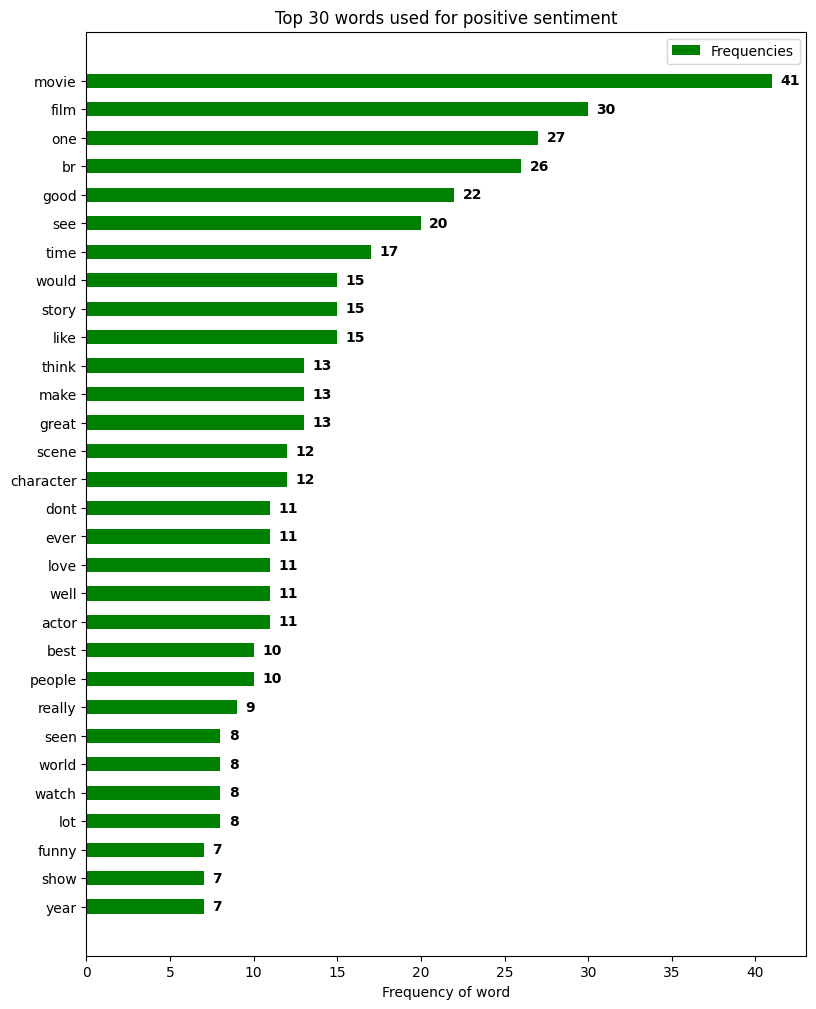

In [18]:
import numpy as np
fig, ax = plt.subplots(figsize=(12, 12))
x = np.arange(N)[::-1]
frequencies = ax.barh(x, top_1_words.values(), color='green', height=0.5, label='Frequencies')
for bar, value in zip(frequencies, top_1_words.values()):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, str(value), va='center', fontweight='bold')
ax.set_yticks(x)
ax.set_yticklabels(top_1_words.keys())
ax.set_xlabel('Frequency of word')
ax.set_title('Top 30 words used for positive sentiment')
ax.legend()

plt.subplots_adjust(left=0.3)
plt.show()

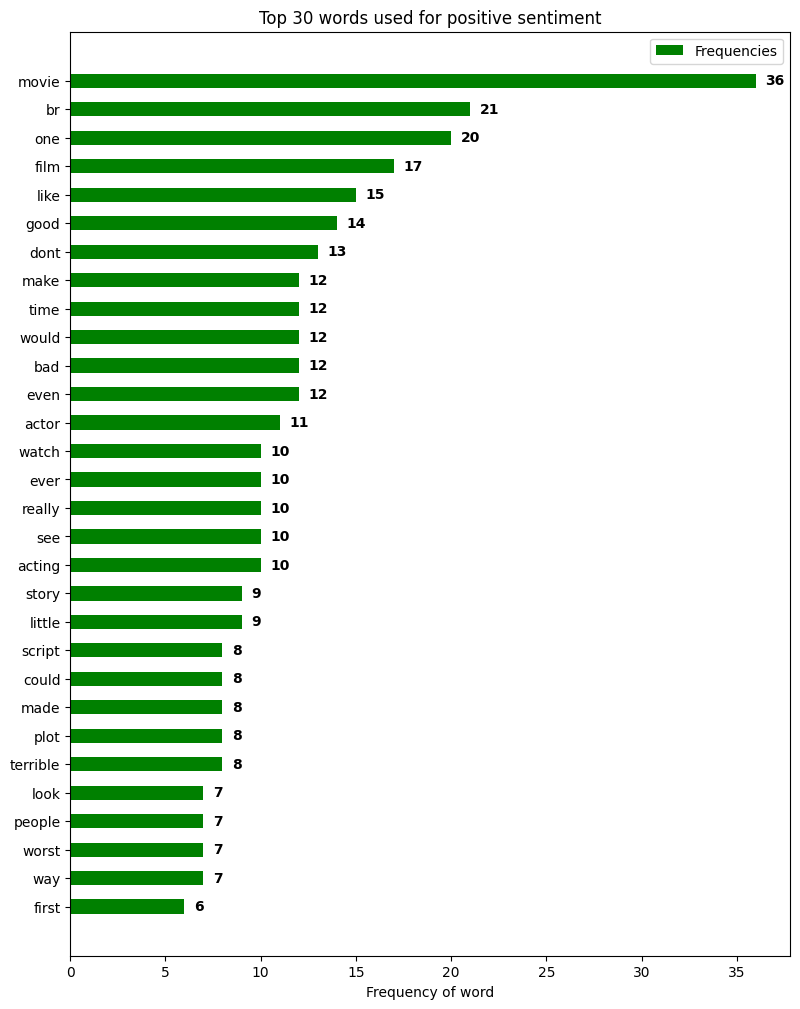

In [19]:
fig, ax = plt.subplots(figsize=(12, 12))
x = np.arange(N)[::-1]
frequencies = ax.barh(x, top_0_words.values(), color='green', height=0.5, label='Frequencies')
for bar, value in zip(frequencies, top_0_words.values()):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, str(value), va='center', fontweight='bold')
ax.set_yticks(x)
ax.set_yticklabels(top_0_words.keys())
ax.set_xlabel('Frequency of word')
ax.set_title('Top 30 words used for positive sentiment')
ax.legend()

plt.subplots_adjust(left=0.3)
plt.show()

In [20]:
positive_reviews_size = len(train_data[train_data['label'] == 1])
negative_reviews_size = len(train_data[train_data['label'] == 0])

positive_review_avg_length = 0
negative_review_avg_length = 0

for words in train_data[train_data['label'] == 1]['cleaned_text']:
    positive_review_avg_length += len(words)

for words in train_data[train_data['label'] == 0]['cleaned_text']:
    negative_review_avg_length += len(words)

positive_review_avg_length /= positive_reviews_size
negative_review_avg_length /= negative_reviews_size

print(f"Positive reviews on average have {positive_review_avg_length} words.\nNegative review on average have {negative_review_avg_length} words.")


Positive reviews on average have 37.81927710843374 words.
Negative review on average have 41.134328358208954 words.


## Semi-supervised learning

### Using Traditional Methods (Label Propagation)

#### Label Propagation for Unlabeled Data

We'll use the `LabelSpreading` technique from `scikit-learn` to propagate labels to the unlabeled data.

In [16]:
import pandas as pd
import numpy as np
from sklearn.semi_supervised import LabelSpreading
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, RMSprop

In [17]:
# Prepare the data for LabelSpreading
X_train = np.vstack(train_data['embedding'].values)
y_train = train_data['label'].values

X_unlabeled = np.vstack(unlabeled_data['embedding'].values)
y_unlabeled = -1 * np.ones(X_unlabeled.shape[0])

X_combined = np.vstack((X_train, X_unlabeled))
y_combined = np.concatenate((y_train, y_unlabeled))

# Label propagation
label_spread = LabelSpreading(kernel='knn', n_neighbors=3)
label_spread.fit(X_combined, y_combined)

# Get the propagated labels
propagated_labels = label_spread.transduction_[-len(unlabeled_data):]

# Create a DataFrame with the propagated labels
propagated_labels_data = unlabeled_data.copy()
propagated_labels_data['label'] = propagated_labels

#### Combine Propagated Labels and Train Data

In [18]:
combined_data = pd.concat([train_data, propagated_labels_data], ignore_index=True)


X_train_combined = np.vstack(combined_data['embedding'].values)
y_train_combined = combined_data['label'].values

#### Build and Train a Neural Network with Early Stopping

In [19]:
model = Sequential([
    Dense(2048, activation=LeakyReLU(alpha=0.01), input_shape=(X_train_combined.shape[1],), kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(512, activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(256, activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(128, activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(64, activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

def lr_scheduler(epoch, lr):
    return lr * 0.97

lr_schedule = lr_scheduler
lr_callback = LearningRateScheduler(lr_schedule)



In [20]:
model.compile(optimizer=Adam(learning_rate=0.003), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

label_propagation_history = model.fit(X_train_combined, y_train_combined,
                    validation_split=0.25, epochs=100, batch_size = 4,
                    callbacks=[lr_callback, early_stopping])

Epoch 1/100
219/219 [==============================] - 12s 6ms/step - loss: 1.1673 - accuracy: 0.5017 - val_loss: 0.6937 - val_accuracy: 0.4914 - lr: 0.0029
Epoch 2/100
219/219 [==============================] - 1s 5ms/step - loss: 0.7446 - accuracy: 0.5109 - val_loss: 0.6802 - val_accuracy: 0.5601 - lr: 0.0028
Epoch 3/100
219/219 [==============================] - 2s 9ms/step - loss: 0.7356 - accuracy: 0.5281 - val_loss: 0.6834 - val_accuracy: 0.7423 - lr: 0.0027
Epoch 4/100
219/219 [==============================] - 2s 10ms/step - loss: 0.7167 - accuracy: 0.5441 - val_loss: 0.5951 - val_accuracy: 0.7079 - lr: 0.0027
Epoch 5/100
219/219 [==============================] - 2s 7ms/step - loss: 0.7021 - accuracy: 0.5624 - val_loss: 0.6503 - val_accuracy: 0.4914 - lr: 0.0026
Epoch 6/100
219/219 [==============================] - 2s 7ms/step - loss: 0.6833 - accuracy: 0.6002 - val_loss: 0.6726 - val_accuracy: 0.5739 - lr: 0.0025
Epoch 7/100
219/219 [==============================] - 2s 7ms/

### Evaluate model

In [21]:
X_test = np.vstack(test_data['embedding'].values)
y_test = test_data['label'].values

label_propagation_test_loss, label_propagation_test_accuracy = model.evaluate(X_test, y_test, batch_size = 1)
print(f'Test Accuracy: {label_propagation_test_accuracy:.2f}')

150/150 [==============================] - 0s 2ms/step - loss: 0.4630 - accuracy: 0.7800
Test Accuracy: 0.78


### Using LLMs

In [22]:
from transformers import AutoTokenizer, AutoModelForCausalLM , AutoModelForSequenceClassification
import torch

directory = '/content/drive/MyDrive/CA7/'

MODEL_ARGS = {
    'Name': 'microsoft/Phi-3-mini-128k-instruct',
    'DType': 'bfloat16'
}

def load_model(model_args):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = AutoModelForCausalLM.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
        torch_dtype=getattr(torch, model_args['DType']),
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
    )

    return model, tokenizer

model, tokenizer = load_model(MODEL_ARGS)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [23]:


model_name = "roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to("cuda")

X_train = train_data['text'].values.tolist()
y_train = train_data['label'].values

X_unlabeled = unlabeled_data['text'].values.tolist()

max_length = 128
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_length)
unlabeled_encodings = tokenizer(X_unlabeled, truncation=True, padding=True, max_length=max_length)

def classify_tokens(model, encodings):
    with torch.no_grad():
        input_ids = torch.tensor(encodings['input_ids']).to("cuda")
        attention_mask = torch.tensor(encodings['attention_mask']).to("cuda")
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()
    return predictions

unlabeled_predictions = classify_tokens(model, unlabeled_encodings)

y_combined[len(y_train):] = unlabeled_predictions

print("Unlabeled Data:", len(unlabeled_data))
print("Training Data:", len(train_data))
print("Test Data:", len(test_data))



# model_name = "bert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name)

# X_train = train_data['text'].values.tolist()
# y_train = train_data['label'].values

# X_unlabeled = unlabeled_data['text'].values.tolist()

# max_length = 64
# train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_length)
# unlabeled_encodings = tokenizer(X_unlabeled, truncation=True, padding=True, max_length=max_length)

# def classify_tokens(model, encodings):
#     with torch.no_grad():
#         input_ids = torch.tensor(encodings['input_ids'])
#         attention_mask = torch.tensor(encodings['attention_mask'])
#         outputs = model(input_ids, attention_mask=attention_mask)
#         logits = outputs.logits
#         predictions = torch.argmax(logits, dim=-1).cpu().numpy()
#     return predictions

# unlabeled_predictions = classify_tokens(model, unlabeled_encodings)

# y_combined[len(y_train):] = unlabeled_predictions

# print("Unlabeled Data:", len(unlabeled_data))
# print("Training Data:", len(train_data))
# print("Test Data:", len(test_data))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unlabeled Data: 1014
Training Data: 150
Test Data: 150


In [24]:
model.save_pretrained(directory)
tokenizer.save_pretrained(directory)

('/content/drive/MyDrive/CA7/tokenizer_config.json',
 '/content/drive/MyDrive/CA7/special_tokens_map.json',
 '/content/drive/MyDrive/CA7/vocab.json',
 '/content/drive/MyDrive/CA7/merges.txt',
 '/content/drive/MyDrive/CA7/added_tokens.json',
 '/content/drive/MyDrive/CA7/tokenizer.json')

In [25]:
unlabeled_predictions_df = pd.DataFrame({'label': unlabeled_predictions})

unlabeled_data_with_labels = unlabeled_data.copy()
unlabeled_data_with_labels['label'] = unlabeled_predictions_df['label']

Storing labeled data results in JSON format for future use:

In [26]:
unlabeled_data_with_labels.drop(columns=['cleaned_text'], inplace=True)
unlabeled_data_with_labels = unlabeled_data_with_labels[['text', 'label', 'embedding']]

output_file = "unlabeled_data_with_labels.jsonl"
unlabeled_data_with_labels.to_json(output_file, orient='records', lines=True)

In [27]:
unlabeled_data_with_labels

,text,label,embedding
0,there is no relation at all between fortier an...,1,"[-0.097577557, -0.1536363065, 0.311417222, 0.0..."
1,in the process of trying to establish the audi...,0,"[-0.0003366936, 0.0877778083, -0.0071643554, 0..."
2,i give this movie 7 out of 10 because the vill...,1,"[-0.275570631, -0.3291363716, 0.079317905, 0.0..."
3,this is the best sci-fi that i have seen in my...,1,"[0.1461943835, -0.2785910368, 0.4456491172, -0..."
4,what an appalling piece of rubbish!!! who are ...,1,"[0.1696606129, 0.354041934, 0.4451519549, -0.0..."
...,...,...,...
1009,unbelievable!<br /><br />this film gets a 7 ou...,1,"[-0.0955021083, 0.0211753864, 0.3570575416, -0..."
1010,sweet romantic drama/comedy about stewart and ...,1,"[0.017505046, -0.0501609854, 0.4082049727, -0...."
1011,"personally, i disdain the jerry springer show,...",1,"[-0.196471706, -0.0579777397, 0.1792553961, -0..."
1012,this film looked promising but it was actually...,1,"[-0.0007334474, -0.1367768645, 0.1660933644, 0..."


In [28]:
def remove_html(text):
    text = re.sub(r"<br \/>", " ", text)
    return text;

unlabeled_data_with_labels['text'] = unlabeled_data_with_labels['text'].apply(remove_html)

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(unlabeled_data_with_labels['text'], unlabeled_data_with_labels['label'], test_size=0.2)

vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = vectorizer.fit_transform(X_train)

X_test_tfidf = vectorizer.transform(X_test)

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_tfidf, y_train)

predictions = logistic_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.7783251231527094


### Evaluating on test data :

In [30]:
unlabeled_data_with_labels = []
read_json(unlabeled_data_with_labels, directory + 'unlabeled_data_with_labels.jsonl')
unlabeled_data_with_labels = pd.DataFrame(unlabeled_data_with_labels)

In [31]:
train_data = pd.concat([train_data[['text', 'label']],unlabeled_data_with_labels[['text', 'label']]], ignore_index=True)
train_data['text'] = train_data['text'].apply(remove_html)
train_data

,text,label
0,fairly good romantic comedy in which i don't t...,1
1,"""dressed to kill"", is one of the best thriller...",1
2,i'm glad that users (as of this date) who like...,1
3,needed an excuse to get out of the house while...,0
4,john candy's performance in once upon a crime ...,1
...,...,...
1159,unbelievable! this film gets a 7 out 0f 10. t...,1
1160,sweet romantic drama/comedy about stewart and ...,1
1161,"personally, i disdain the jerry springer show,...",0
1162,this film looked promising but it was actually...,1


In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [33]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

MAX_LENGTH = 128
BATCH_SIZE = 32
LEARNING_RATE = 6e-3
EPOCHS = 5

def schedule_lr(epoch, lr):
  return lr * 0.9

learning_rate_scheduler = schedule_lr
lr_callback = LearningRateScheduler(learning_rate_scheduler)

train_dataset = CustomDataset(train_data['text'], train_data['label'], tokenizer, MAX_LENGTH)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = CustomDataset(test_data['text'], test_data['label'], tokenizer, MAX_LENGTH)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [36]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

for epoch in range(EPOCHS):
    model.train()
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].numpy()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_labels = logits.argmax(axis=1).cpu().numpy()

        predictions.extend(predicted_labels)
        true_labels.extend(labels)

accuracy = accuracy_score(true_labels, predictions)
print("Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Accuracy: 0.48
